# Knife MI analysis

In [56]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm as tqdm
import numpy as np
import json
import sklearn

from utils import get_features
from models.model_paths import get_model_path

In [216]:
DATASET = "ClinTox"
LENGTH = 2048
MDS_DIM = 64

DESCRIPTORS = [
            "ecfp",
            "estate",
            "fcfp",
            "erg",
            "rdkit",
            "topological",
            "avalon",
            "maccs",
            "secfp",
            "scaffoldkeys",
            "cats",
            "gobbi",
            "pmapper",
            "cats/3D",
            "gobbi/3D",
            "pmapper/3D",
            "ScatteringWavelet",
        ]

with open(f"data/{DATASET}/smiles.json", "r") as f:
    smiles = json.load(f)

100%|██████████| 17/17 [00:00<00:00, 42.06it/s]


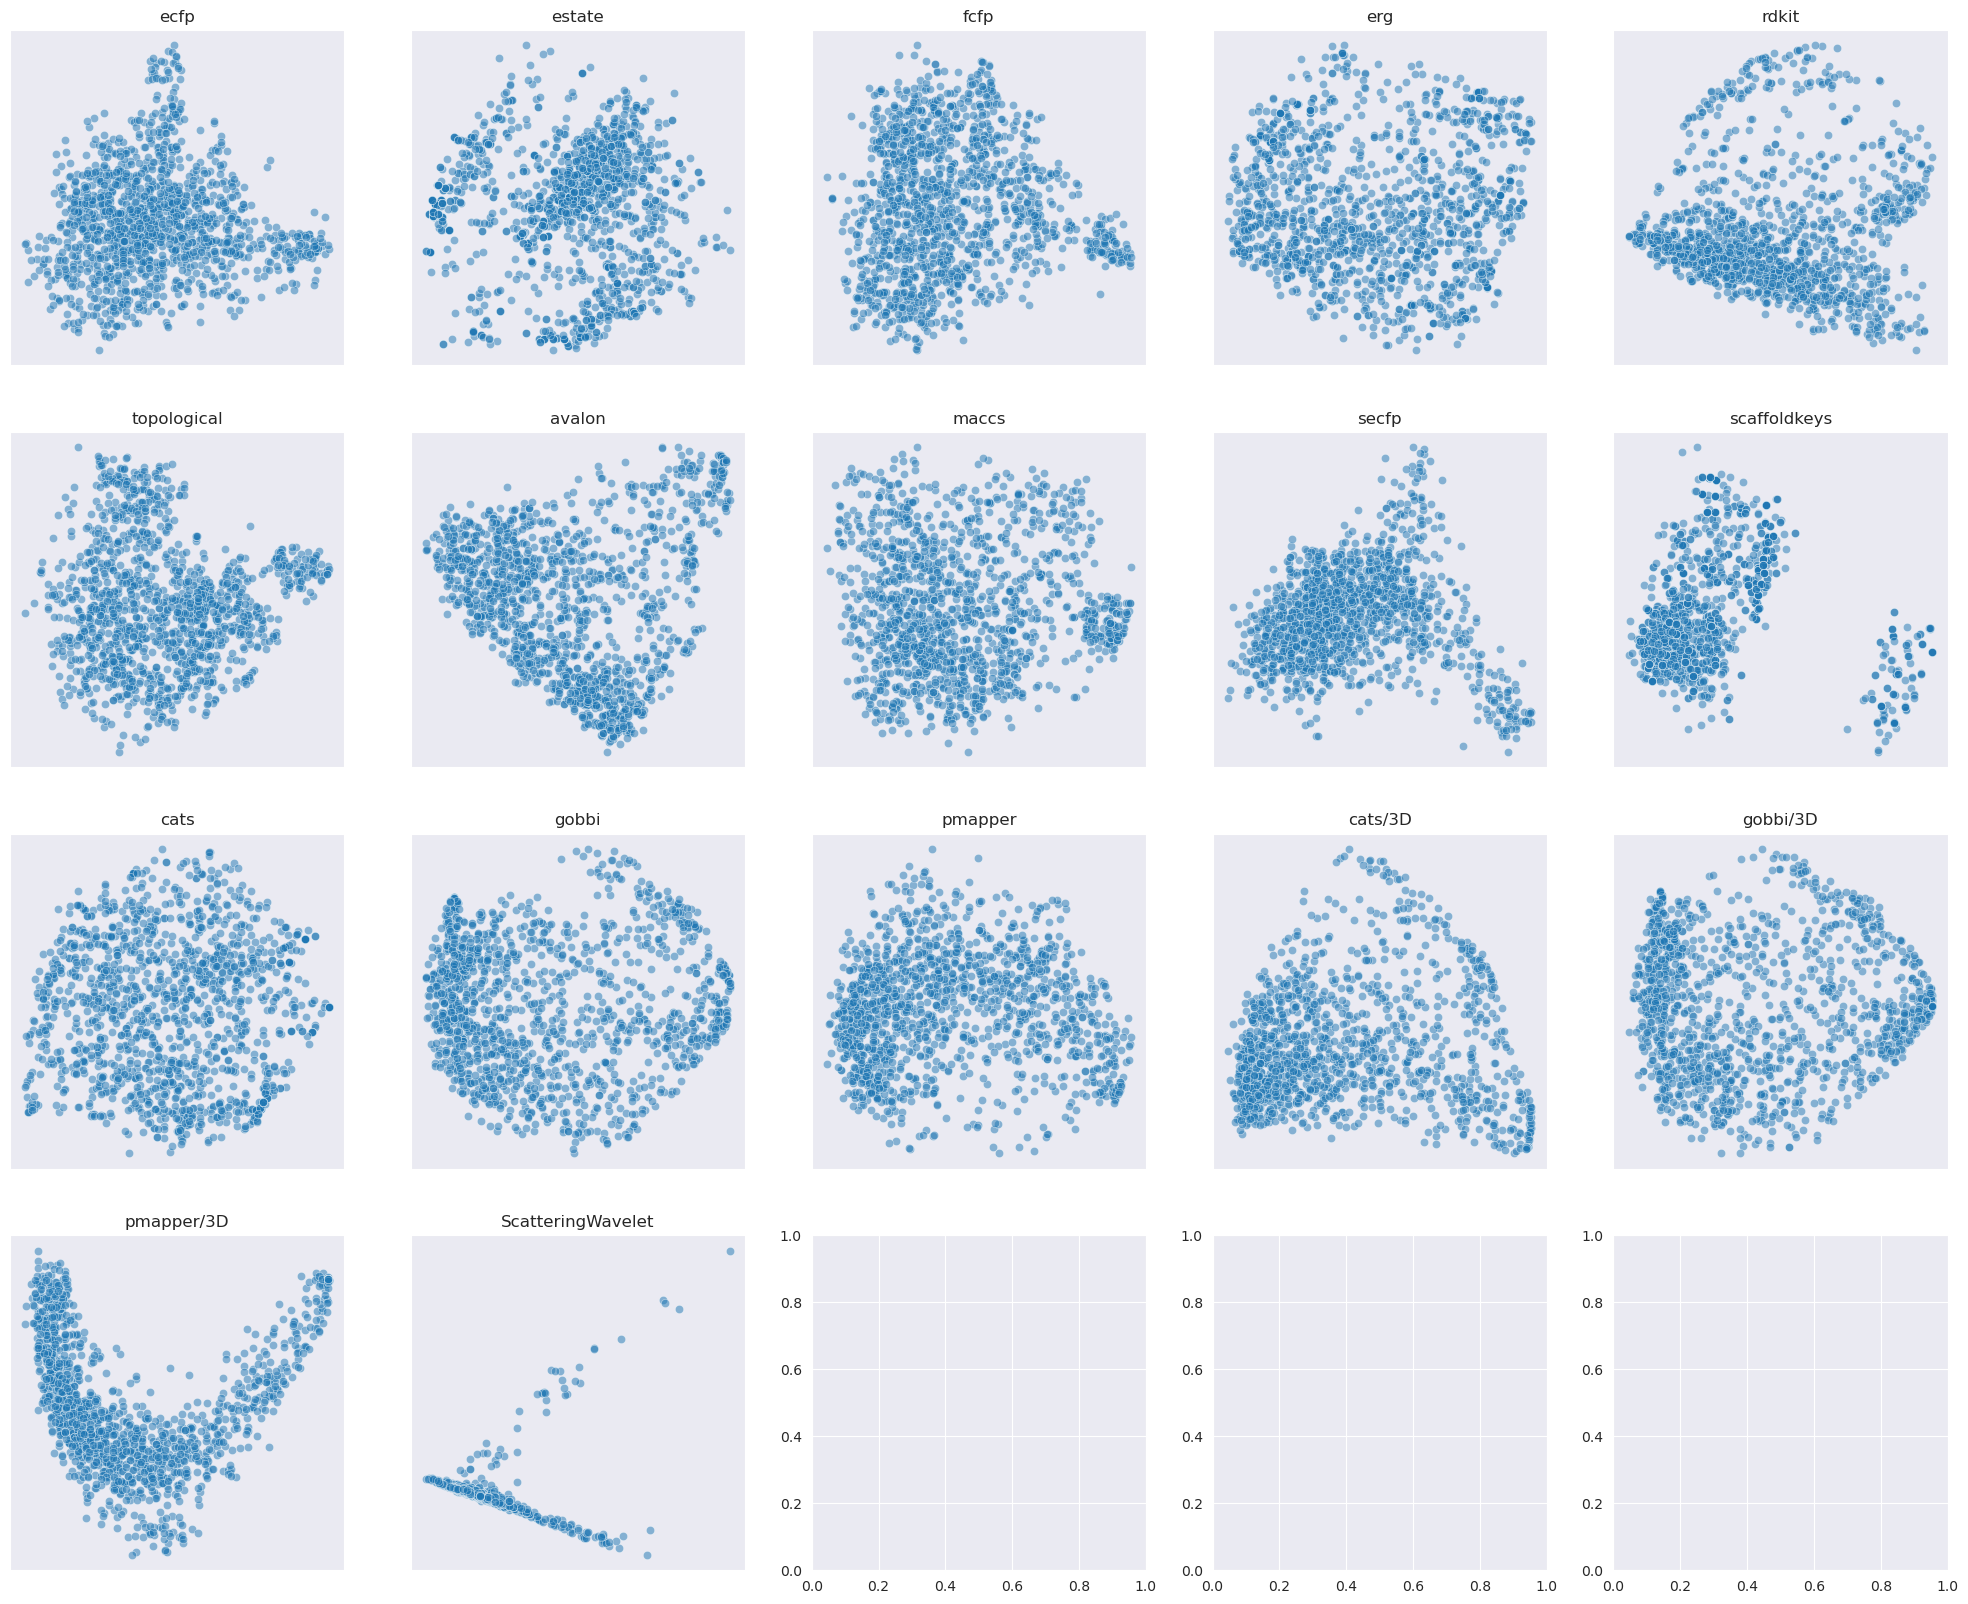

In [80]:
FIGSIZE = 5
fig,axes = plt.subplots(4,5,figsize=(FIGSIZE*5,FIGSIZE*4))
axes = axes.flatten()

for i,d in enumerate(tqdm(DESCRIPTORS)):
    embeddings = get_features(smiles, name=d, length=LENGTH, mds_dim=MDS_DIM, dataset=DATASET, feature_type="descriptor", normalize=True)
    pca = sklearn.decomposition.PCA(n_components=2)
    embeddings_red = pca.fit_transform(embeddings)
    #tsne = sklearn.manifold.TSNE(n_components=2, n_iter=250)
    #embeddings_red = tsne.fit_transform(embeddings_red)
    df = pd.DataFrame(embeddings_red, columns=["PC1", "PC2"])
    df["smiles"] = smiles
    sns.scatterplot(data=df, x="PC1", y="PC2",alpha=0.5, ax=axes[i])
    axes[i].set_title(d)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [76]:
embeddings.shape

torch.Size([1439, 300])

In [81]:
len(smiles)

1439

In [36]:
models_pca = ["ChemBertMLM-5M", "ChemBertMTR-5M", "EdgePred","GraphMVP", "AttributeMask","Not-trained"]
MODELS = get_model_path(models=models_pca)

1453 torch.Size([1453, 600])


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1453 torch.Size([1453, 384])


/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


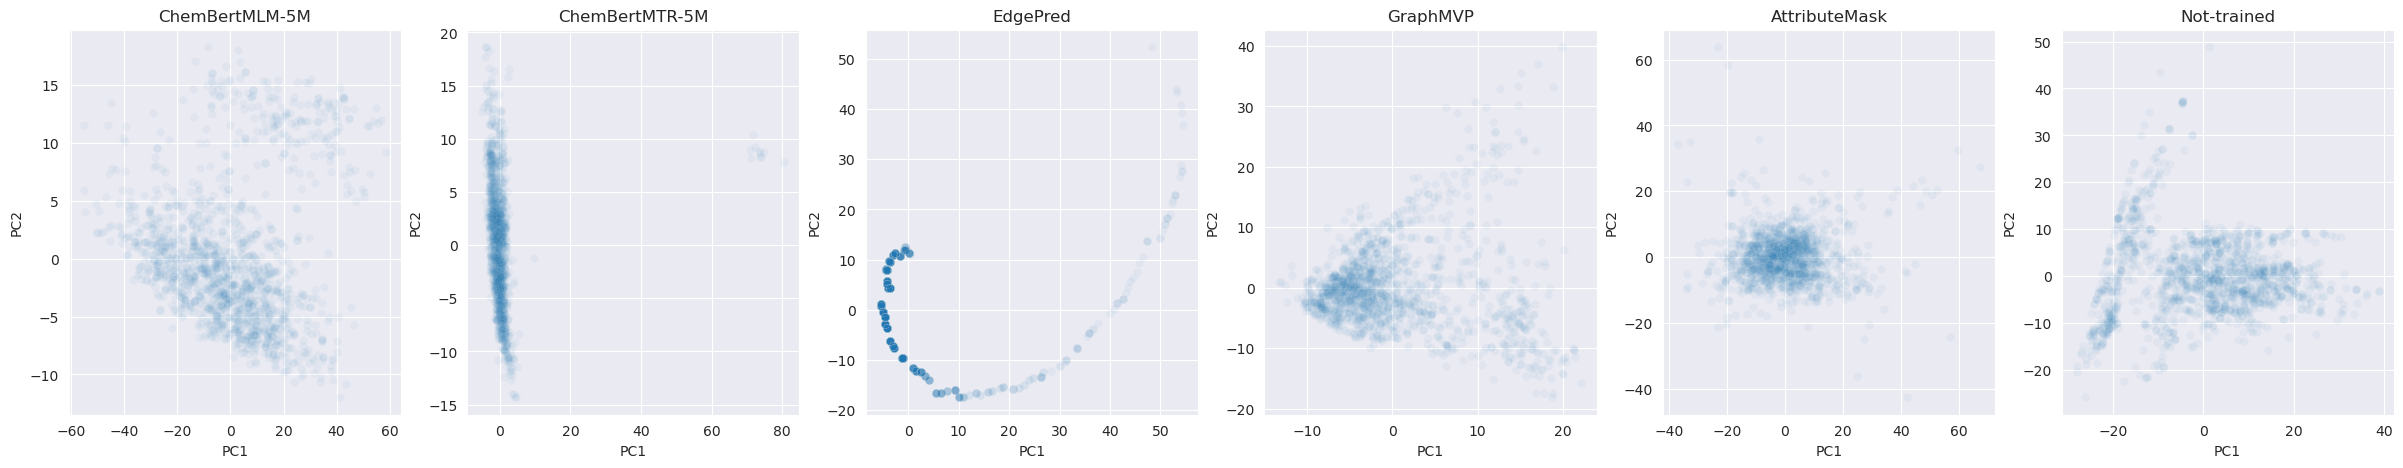

In [37]:
fig,axes = plt.subplots(1,len(models_pca),figsize=(len(models_pca)*5,5))
for i,model in enumerate(models_pca):
    embeddings = get_features(smiles, name=model, length=LENGTH, mds_dim=MDS_DIM, dataset=DATASET, feature_type="model", normalize=True, path = MODELS.get(model, None))
    # nromalize embeddings
    embeddings = (embeddings - embeddings.mean(axis=0))/(embeddings.std(axis=0) +1e-8)
    pca = sklearn.decomposition.PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    df = pd.DataFrame(embeddings_pca, columns=["PC1", "PC2"])
    df["smiles"] = smiles
    sns.scatterplot(data=df, x="PC1", y="PC2",alpha=0.05, ax = axes[i])
    axes[i].set_title(model)



In [217]:
full_df_loss_cond = []
full_df_loss_marg = []

for file in tqdm(os.listdir("results/losses")):
    #one plot for each model showing the loss on all descriptors. Files are {model}_{descriptor}_{run}_XY.csv
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[-2] == str(LENGTH):
            if file_split[-1] == "marg":
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join("results/losses", file))
                full_df_loss_marg.append(df_tmp)
            else:
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join("results/losses", file))
                full_df_loss_cond.append(df_tmp)

full_df_loss_cond = pd.concat(full_df_loss_cond)
full_df_loss_marg = pd.concat(full_df_loss_marg)



100%|██████████| 136/136 [00:03<00:00, 41.21it/s]


100%|██████████| 17/17 [00:00<00:00, 34.51it/s]


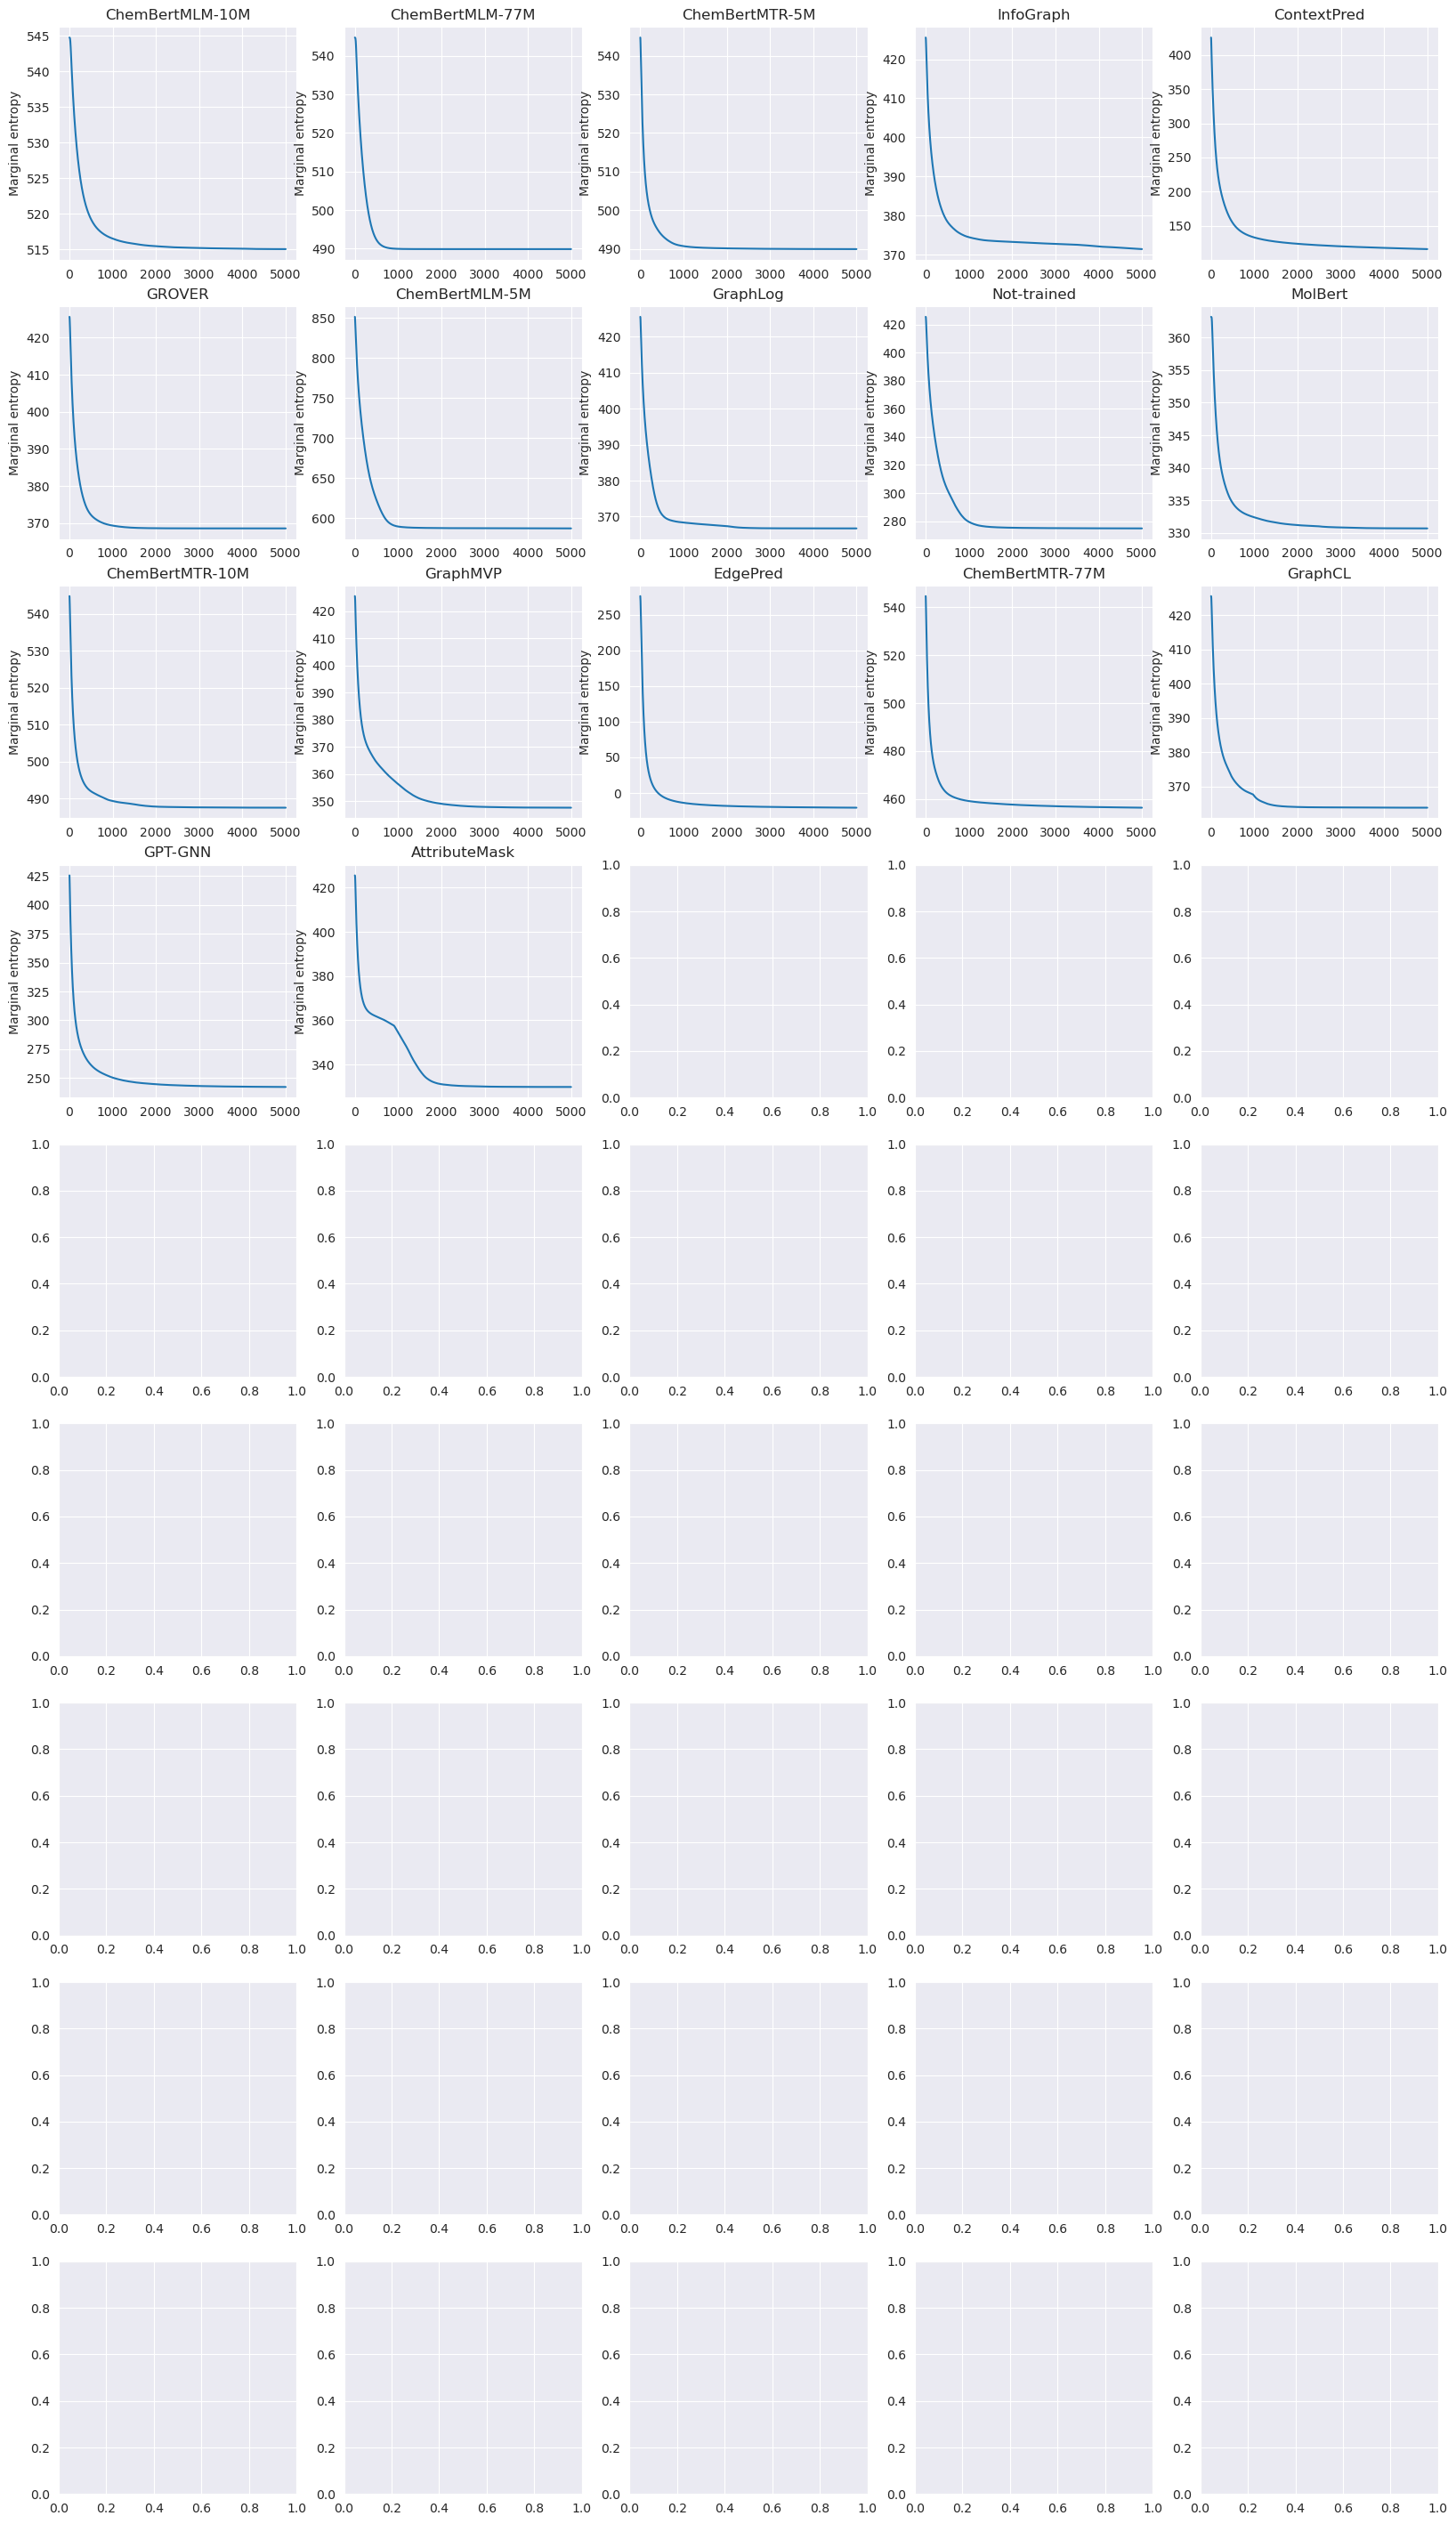

In [218]:
n_rows = np.ceil(full_df_loss_cond.Y.nunique()/4).astype(int)
n_cols = 5
fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,4*n_rows))
axes = axes.flatten()
for i, model in enumerate(tqdm(full_df_loss_marg.X.unique())):
    df_tmp = full_df_loss_marg[full_df_loss_marg.X == model]
    sns.lineplot(data=df_tmp, x="epoch", y="marg_ent", hue="X", ax=axes[i], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i].set_title(model)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Marginal entropy")

In [219]:
# remove EdgePred
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.Y != "EdgePred"]
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.X != "EdgePred"]

full_df_loss_margin = full_df_loss_marg[full_df_loss_marg.X != "EdgePred"]

100%|██████████| 33/33 [00:48<00:00,  1.47s/it]


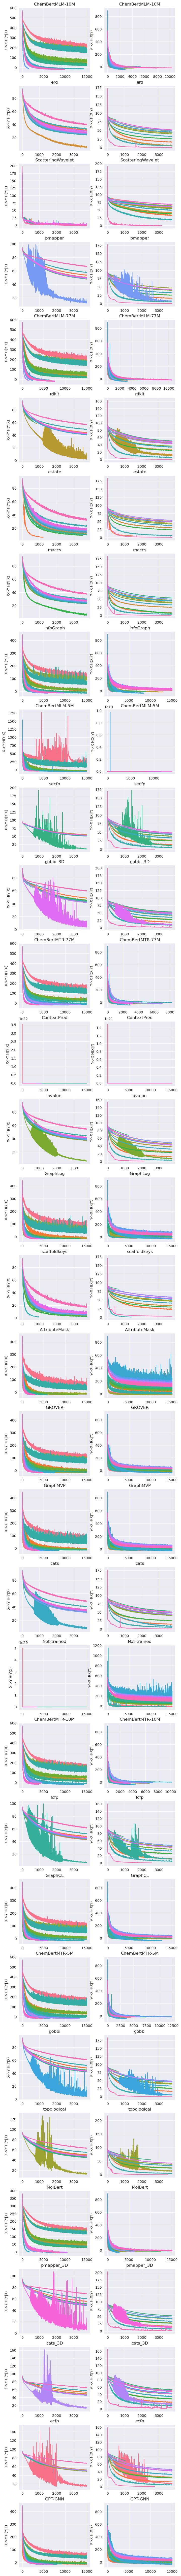

In [220]:
n_rows = full_df_loss_cond.Y.nunique()
n_cols = 2
fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,4*n_rows))


for i, model in enumerate(tqdm(full_df_loss_cond.Y.unique())):
    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "X->Y")]
    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,0], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i,0].set_title(model)
    axes[i,0].set_xlabel("")
    axes[i,0].set_ylabel("X->Y H(Y|X)")

    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "Y->X")]

    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,1], estimator=None, errorbar= None, n_boot=0, legend=False)
    axes[i,1].set_title(model)
    axes[i,1].set_xlabel("")
    axes[i,1].set_ylabel("Y->X H(X|Y)")


## MI between descriptors and embeddings

In [221]:
import os
import numpy as np
all_df = []
for file in os.listdir("results"):
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[-1] == str(LENGTH):
            all_df.append(pd.read_csv(os.path.join("results", file)))
df = pd.concat(all_df)

df =df[df.Y.isin(DESCRIPTORS)]

In [222]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [X, Y, I(Y), I(Y|X), I(X->Y), I(X), I(X|Y), I(Y->X), Y_dim, X_dim, is_desc_discrete]
Index: []

In [201]:
df = df[
        ~(df.X.isin(["EdgePred2048", "ContextPred2048", "Not-trained2048"]) | df.Y.isin(["EdgePred", "ContextPred", "Not-trained"]))
]

In [202]:
df.sample(5)

X                Y        I(Y)      I(Y|X)     I(X->Y)  \
2          GraphMVP2048        InfoGraph  390.187600  186.919304  203.268296   
16  ChemBertMTR-77M2048  ChemBertMLM-10M  545.062751  354.613156  190.449596   
5     AttributeMask2048           GROVER  398.486917  303.487931   94.998986   
14   ChemBertMTR-5M2048         GraphLog  392.717598   82.493327  310.224271   
1           GPT-GNN2048    AttributeMask  380.583576  255.698463  124.885113   

          I(X)      I(X|Y)     I(Y->X)  Y_dim  X_dim  is_desc_discrete  
2   395.471456  197.602304  197.869152    300    300             False  
16  517.244068  375.871064  141.373004    384    384             False  
5   380.583575  182.749643  197.833932    300    300             False  
14  522.655347  392.443005  130.212342    300    384             False  
1   317.547856  219.152585   98.395271    300    300             False

In [223]:
df_non_diag = df[df.X.apply(lambda x: x[:-4]) != df.Y]

In [224]:
gb = df_non_diag.groupby("X").mean()

for y in df.X.unique():
    df["I(X->Y)"][(df.X.apply(lambda x: x[:-4]) == df.Y) & (df.X == y)] = gb.loc[y, "I(X->Y)"]

for y in df.X.unique():
    df["I(Y->X)"][(df.X.apply(lambda x: x[:-4]) == df.Y) & (df.X == y)] = gb.loc[y, "I(X->Y)"]

/tmp/ipykernel_8694/3083827661.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb = df_non_diag.groupby("X").mean()
/tmp/ipykernel_8694/3083827661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["I(X->Y)"][(df.X.apply(lambda x: x[:-4]) == df.Y) & (df.X == y)] = gb.loc[y, "I(X->Y)"]
/tmp/ipykernel_8694/3083827661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["I(X->Y)"][(df.X.apply(lambda x: x[:-4]) == df.Y) & (


## Clustermap

In [225]:
df["I(Y->X)/dim"] = df["I(Y->X)"]/df["X_dim"]
df["I(X->Y)/dim"] = df["I(X->Y)"]/df["Y_dim"]

df["I(Y->X)/I(X)"] = df["I(Y->X)"]/df["I(X)"]
df["I(X->Y)/I(Y)"] = df["I(X->Y)"]/df["I(Y)"]

df["I(Y->X)/I(X)"] = df["I(Y->X)"]/df["I(X)"]
df["I(X->Y)/I(Y)"] = df["I(X->Y)"]/df["I(Y)"]



df["I(Y->X) - I(X->Y)"] =  df["I(Y->X)"]-df["I(X->Y)"]
df["I(Y->X)/dim - I(X->Y)/dim"] = df["I(Y->X)/dim"]-df["I(X->Y)/dim"]
df["I(Y->X)/I(X) - I(X->Y)/I(Y)"] = df["I(Y->X)/I(X)"]-df["I(X->Y)/I(Y)"]


df = df.dropna()

In [226]:
df = df[df.Y!= "EdgePred"]

In [227]:
keys = [
    "I(Y->X)", "I(X->Y)", "I(Y->X)/dim", "I(X->Y)/dim",
    "I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim",
]

for key in keys:
    df[key + "_normed"] = df.apply(lambda x: x[key] - df[(df.Y == "Not-trained") & (df.X == x.X)][key].values[0], axis=1)


IndexError: index 0 is out of bounds for axis 0 with size 0

<AxesSubplot:xlabel='X_dim', ylabel='I(Y->X)/I(X)'>

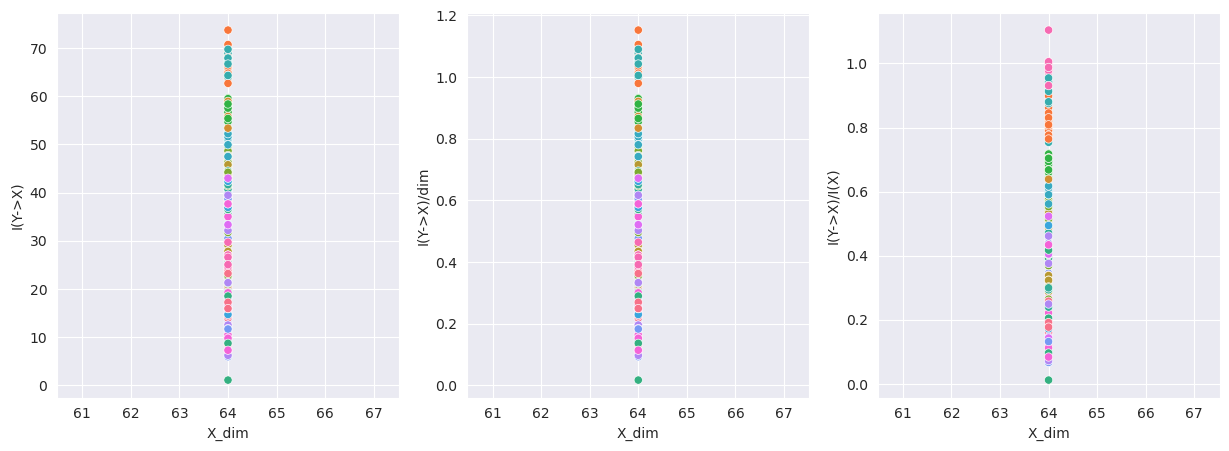

In [228]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(Y->X)", x="X_dim", hue="X", ax=axes[0], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/dim", x="X_dim", hue="X", ax=axes[1], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/I(X)", x="X_dim", hue="X", ax=axes[2], legend=False)


<AxesSubplot:xlabel='Y_dim', ylabel='I(X->Y)/I(Y)'>

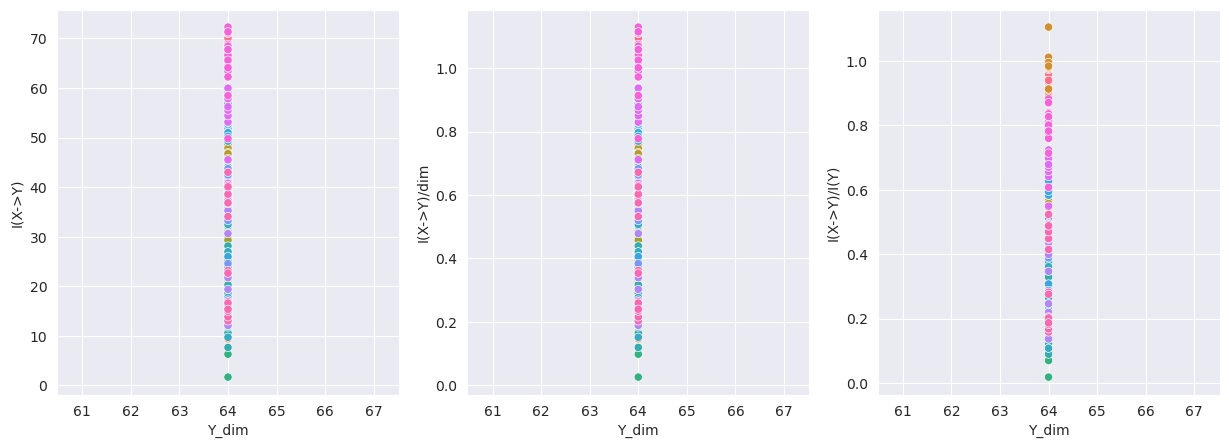

In [229]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(X->Y)", x="Y_dim", hue="Y", ax=axes[0], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/dim", x="Y_dim", hue="Y", ax=axes[1], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/I(Y)", x="Y_dim", hue="Y", ax=axes[2], legend=False)


In [230]:
def plot_cmap(df, keys, cmap = "copper", vmin = None, vmax = None, center = None):

    for i, key in enumerate(keys):
        df_pivot = df.pivot_table(index="X", columns="Y", values=key, aggfunc="mean")
        from scipy.cluster.hierarchy import linkage
        link = linkage(df_pivot, method="ward")
        cluster = sns.clustermap(
            df_pivot, row_linkage=link, col_linkage=link,
            cmap=cmap, figsize=(8,8), vmin=vmin, vmax=vmax, center=center
        )
        cluster.savefig("fig/cluster_{}.png".format(i))
        plt.clf()

    import matplotlib.image as mpimg

    fig, axes = plt.subplots(1,len(keys), figsize=(8*len(keys),8))
    for i, key in enumerate(keys):
        axes[i].imshow(mpimg.imread("fig/cluster_{}.png".format(i)))
        axes[i].axis("off")
        axes[i].set_title(key)
    plt.show()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

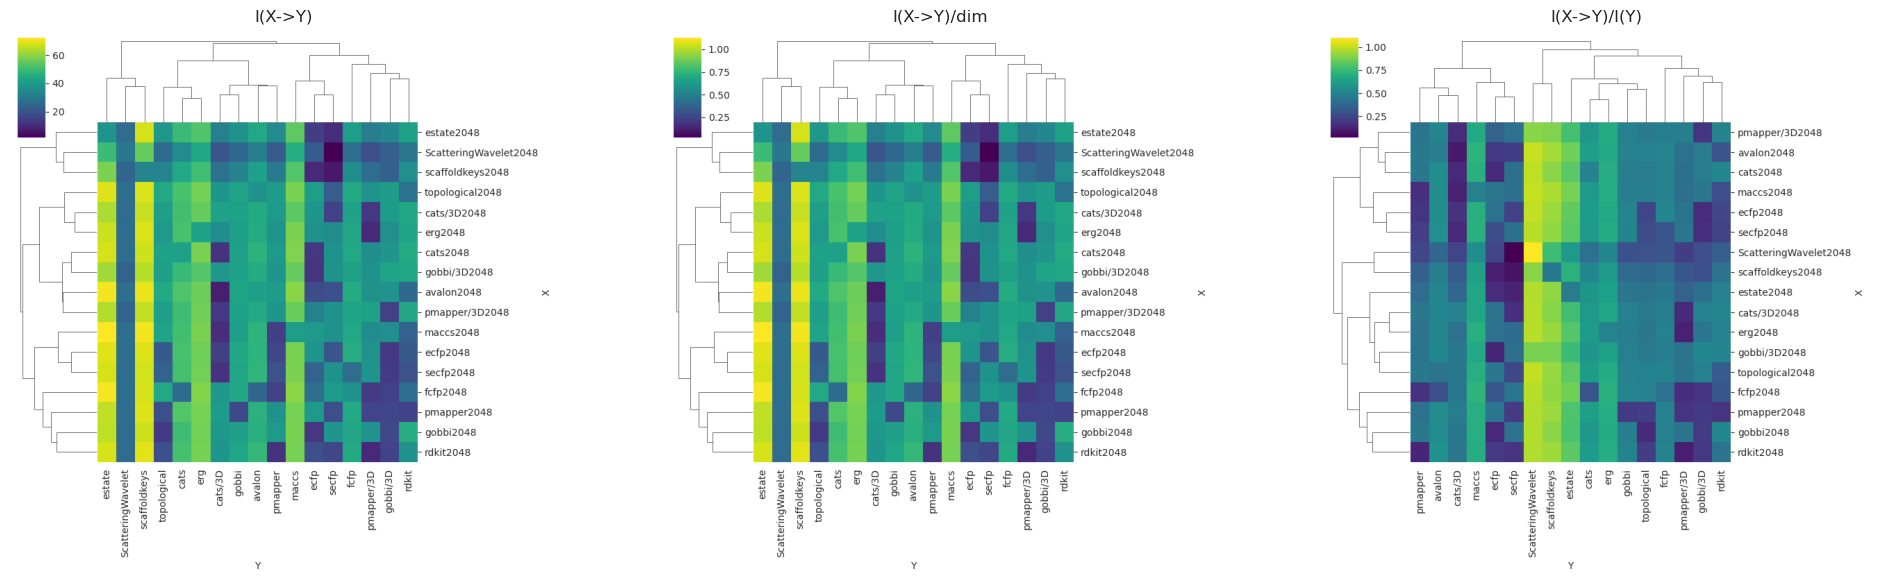

In [231]:
%matplotlib inline
plot_cmap(
    df[df.X_dim>30],
    ["I(X->Y)", "I(X->Y)/dim", "I(X->Y)/I(Y)"],
    cmap="viridis"
)

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

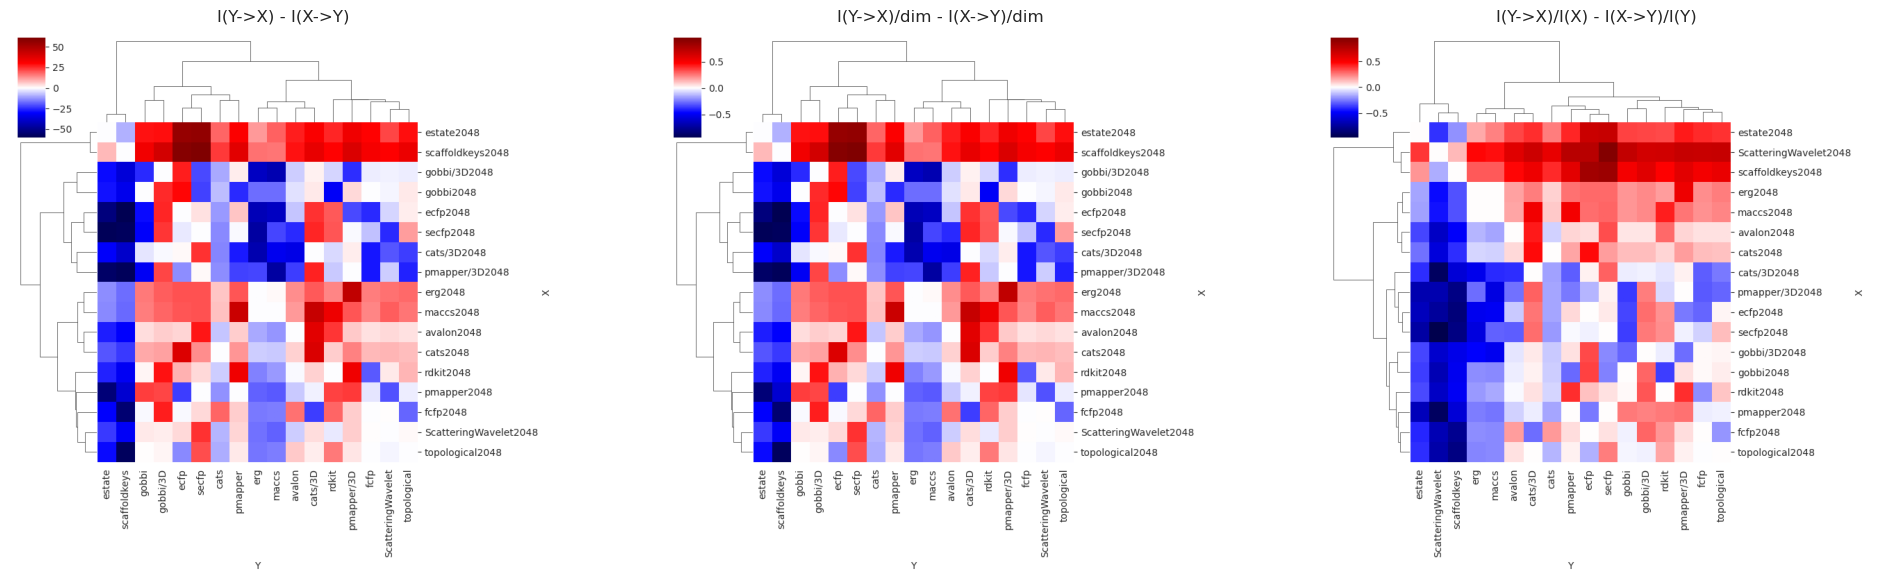

In [232]:
plot_cmap(
    df[df.X_dim>30],
    ["I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim", "I(Y->X)/I(X) - I(X->Y)/I(Y)"],
    cmap="seismic",
    center=0
)

<AxesSubplot:xlabel='X', ylabel='I(Y->X)'>

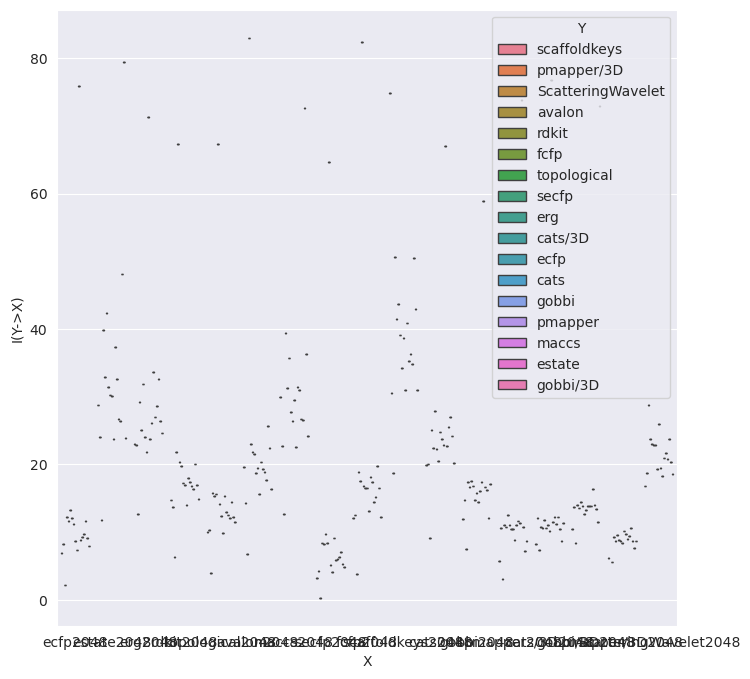

In [128]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(data=df, x="X", y="I(Y->X)", hue="Y")

In [ ]:
sns.boxplot(data=df[df.Y != "Not-trained"], x="X", y="I(Y->X)", hue="Y")

# Fine-tuning

In [ ]:
!pip install networkx==2.8.8

In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html --force

In [ ]:
import os
from tdc.single_pred import Tox

from sklearn.model_selection import train_test_split
import datamol as dm
import pandas as pd
import numpy as np
import torch

from evaluation import get_dataloaders, Feed_forward
from precompute_3d import precompute_3d

df = Tox(name="ClinTox").get_data()
mols, smiles = precompute_3d(df["Drug"].to_numpy(), "ClinTox")
valid_indices = []
mols_valid = []
i_mol = 0
for i,s in enumerate(df["Drug"]):
    if dm.to_smiles(dm.to_mol(s), True, False) in smiles and not "*" in s:
        df["Drug"].iloc[i] = dm.to_smiles(dm.to_mol(s), True, False)
        valid_indices.append(i)
        mols_valid.append(mols[i_mol])
        i_mol += 1

df = df.iloc[valid_indices]
df["Mol"] = mols_valid

smiles = df["Drug"].to_numpy()
y = df["Y"].to_numpy()

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
df.sample(5)

In [ ]:
def run_expe(model_path = "backbone_pretrained_models/GraphLog/Contextual.pth", desc_name="", n_epochs = 100, plot=False):
    dataloader_train, dataloader_test, input_dim = get_dataloaders(smiles_train, y_train, smiles_test, y_test, desc_name=desc_name, model_path=model_path)
    model = Feed_forward(
        input_dim = input_dim,
        hidden_dim = 128,
        output_dim = 1,
        n_layers = 1,
        d_rate=0.3,
        norm="batch"
    )
    model.train_model(dataloader_train, dataloader_test, n_epochs=n_epochs)
    model_name = "None" if model_path=="None" else model_path.split("/")[-2] + " "
    if plot:
        model.plot_loss(title = model_name + " " + desc_name)
    return model

In [ ]:
descriptors = [
            "physchem",
            "ecfp-count",
            "ecfp",
            "estate",
            "erg",
            "rdkit",
            "topological",
            "avalon",
            "maccs",
            "scaffoldkeys",
            "cats",
            "default",
            "gobbi",
            "pmapper",
            "cats/3D",
            "gobbi/3D",
            "pmapper/3D",
        ]

In [ ]:
df_mi = pd.read_csv("resultsClinTox.csv").groupby(["X", "Y"])["I(X->Y)"].mean()

In [ ]:
from tqdm import tqdm
df_desc = {"descriptor":[], "best_acc": [], "best_f1":[], "best_roc":[], "best_aucpr":[]}

N_RUNS = 5
p_bar = tqdm(total=len(descriptors) * N_RUNS, desc="Fine tuning",position=0, leave=True)

for d in descriptors:
        dataloader_train, dataloader_test, input_dim = get_dataloaders(
            df_train.Drug, y_train, df_test.Drug, y_test,df_train["Mol"], df_test["Mol"], desc_name=d, model_path="None")
        for _ in range(N_RUNS):
            df_desc["descriptor"].append(d)
            model = Feed_forward(
                input_dim = input_dim,
                hidden_dim = 128,
                output_dim = 1,
                n_layers = 1,
                d_rate=0.3,
                norm="batch"
            )
            model.train_model(dataloader_train, dataloader_test, n_epochs=300)
            best_acc = np.max(model.test_acc)
            df_desc["best_acc"].append(best_acc)
            df_desc["best_f1"].append(np.max(model.test_f1))
            df_desc["best_roc"].append(np.max(model.test_roc))
            df_desc["best_aucpr"].append(np.max(model.test_aucpr))
            p_bar.update(1)



In [ ]:
df_desc = pd.DataFrame(df_desc)
df_desc


In [ ]:
MODEL_PATH = "backbone_pretrained_models"
MODELS = {}
# For every directory in the folder
for model_name in os.listdir(MODEL_PATH):
    # For every file in the directory
    for file_name in os.listdir(os.path.join(MODEL_PATH, model_name)):
        # If the file is a .pth file
        if file_name.endswith(".pth"):
            MODELS[model_name] = os.path.join(MODEL_PATH, model_name, file_name)
MODELS["Not-trained"] = ""

In [ ]:
from tqdm import tqdm
df_model = {"model":[], "best_acc": [], "best_f1":[], "best_roc":[], "best_aucpr":[]}

N_RUNS = 5
p_bar = tqdm(total=len(MODELS) * N_RUNS, desc="Fine tuning",position=0, leave=True)

for model_name, model_path in MODELS.items():
        dataloader_train, dataloader_test, input_dim = get_dataloaders(
            df_train.Drug, y_train, df_test.Drug, y_test,df_train["Mol"], df_test["Mol"], desc_name="None", model_path=model_path)
        for _ in range(N_RUNS):
            df_model["model"].append(model_name)
            model = Feed_forward(
                input_dim = input_dim,
                hidden_dim = 128,
                output_dim = 1,
                n_layers = 1,
                d_rate=0.3,
                norm="batch"
            )
            model.train_model(dataloader_train, dataloader_test, n_epochs=300)
            best_acc = np.max(model.test_acc)
            df_model["best_acc"].append(best_acc)
            df_model["best_f1"].append(np.max(model.test_f1))
            df_model["best_roc"].append(np.max(model.test_roc))
            df_model["best_aucpr"].append(np.max(model.test_aucpr))
            p_bar.update(1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(32,16))
for i,metric in enumerate(["best_f1", "best_roc", "best_aucpr"]):
    sns.barplot(data=df_desc.sort_values("best_aucpr"), x="descriptor", y=metric, hue="descriptor", ax = axes[i])
    axes[i].set_ylim(max(0,df_desc[metric].min()-0.05), min(1,df_desc[metric].max() + 0.05))
plt.show()

In [ ]:
df_model = pd.DataFrame(df_model)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(32,16))
for i,metric in enumerate(["best_f1", "best_roc", "best_aucpr"]):
    sns.barplot(data=df_model.sort_values("best_aucpr"), x="model", y=metric, hue="model", ax = axes[i])
    axes[i].set_ylim(max(0,df_desc[metric].min()-0.05), min(1,df_desc[metric].max() + 0.05))
plt.show()

In [ ]:
df_model

In [ ]:
df_mi

In [ ]:
df_mi = pd.read_csv("resultsClinTox.csv")
df_mi["I(X->Y)_normed"] = df_mi.apply(lambda x: x["I(X->Y)"] - df_mi[(df.Y == "Not-trained") & (df_mi.X == x.X)]["I(X->Y)"].values[0], axis=1)
df_mi["I(Y->X)_normed"] = df_mi.apply(lambda x: x["I(Y->X)"] - df_mi[(df.Y == "Not-trained") & (df_mi.X == x.X)]["I(Y->X)"].values[0], axis=1)


In [ ]:
hue_order = df_model.model.unique()
fig, axess = plt.subplots(len(descriptors),3,figsize=(3*7,len(descriptors)*7))
first = True
for descriptor, axes in zip(descriptors, axess):
    df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
    df_plot = df_plot[df_plot.descriptor == descriptor]
    for i,(metric, ax) in enumerate(zip(["best_f1", "best_roc", "best_aucpr"], axes)):
        #Scatterplot with linear regression amd corr-coefficient
        sns.regplot(data=df_plot, y=metric, x="I(X->Y)_normed", ax =ax, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
        #display correlation coefficient
        corr = df_plot[[metric, "I(X->Y)_normed"]].corr().iloc[0,1]
        ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.set_title("I(X->Y)_normed " + descriptor + " " + str(df_desc[df_desc.descriptor == descriptor][metric].mean())[:4])


plt.show()

In [ ]:
hue_order = df_model.model.unique()
fig, axess = plt.subplots(len(descriptors),3,figsize=(3*7,len(descriptors)*7))
first = True
for descriptor, axes in zip(descriptors, axess):
    df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
    df_plot = df_plot[df_plot.descriptor == descriptor]
    for i,(metric, ax) in enumerate(zip(["best_f1", "best_roc", "best_aucpr"], axes)):
        #Scatterplot with linear regression amd corr-coefficient
        sns.regplot(data=df_plot, y=metric, x="I(Y->X)_normed", ax =ax, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
        #display correlation coefficient
        corr = df_plot[[metric, "I(Y->X)_normed"]].corr().iloc[0,1]
        ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')

        ax.set_title("I(Y->X)_normed " +descriptor + " " + str(df_desc[df_desc.descriptor == descriptor][metric].mean())[:4])
plt.show()

We now also consider a score that aggregates all MIs by suming all normalized MIs weigthed with the descriptor's best performance


In [ ]:
df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
df_tmp_descriptors = df_desc.rename(columns={k: k+"_desc" for k in ["best_f1", "best_roc", "best_aucpr"]})
df_plot = df_plot.merge(df_tmp_descriptors, left_on="descriptor", right_on="descriptor")
df_plot["sum_I(X->Y)_item"] = df_plot["I(X->Y)_normed"] * df_plot["best_aucpr_desc"]
df_plot["sum_I(Y->X)_item"] = df_plot["I(Y->X)_normed"] * df_plot["best_aucpr_desc"]

sum_values = df_plot.groupby("model")[["sum_I(X->Y)_item", "sum_I(Y->X)_item"]].sum().reset_index().rename(columns={"sum_I(X->Y)_item":"sum_I(X->Y)", "sum_I(Y->X)_item":"sum_I(Y->X)"})

df_plot = df_plot.merge(sum_values, left_on="model", right_on="model")


In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="sum_I(X->Y)", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "sum_I(X->Y)"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( desc->model ) - \mathcal{I}(desc->model_{NT})$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( desc->model )$ score's correlation to the best performance of each evaluated model")

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="sum_I(Y->X)", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "sum_I(Y->X)"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( model-> desc) - \mathcal{I}(model_{NT} -> desc)$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( model-> desc)$ score's correlation to the best performance of each evaluated model")

In [ ]:
df_plot["compression"] = df_plot["sum_I(Y->X)"] - df_plot["sum_I(X->Y)"]

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="compression", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "compression"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( model-> desc) - \mathcal{I}(model_{NT} -> desc)$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( model-> desc)$ score's correlation to the best performance of each evaluated model")

In [ ]:
df_plot["compression_dummy"] = (df_plot["sum_I(X->Y)"] - df_plot["sum_I(X->Y)"].max())/(df_plot["sum_I(X->Y)"].min() - df_plot["sum_I(X->Y)"].max()) - (df_plot["sum_I(Y->X)"] - df_plot["sum_I(Y->X)"].max())/(df_plot["sum_I(Y->X)"].min() - df_plot["sum_I(Y->X)"].max())

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="compression_dummy", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "compression_dummy"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "Weird compression stuff"
)

fig.suptitle("Really weird compression stuff")

In [ ]:
from torch_geometric.datasets import ZINC

In [ ]:
dataset = ZINC(root='/tmp/ZINC', subset=True, split='val')

In [ ]:
from tdc_dataset import get_dataset

In [ ]:
def get_dataset(dataset: str):
    try:
        df = correspondancy_dict[dataset](name=dataset).get_data()
    except:
        label_list = retrieve_label_name_list(dataset)
        df = correspondancy_dict[dataset](name=dataset, label_name=label_list[0]).get_data()
    return df

In [ ]:
df = get_dataset("QM7b")

In [233]:
from moleculenet_encoding import mol_to_graph_data_obj_simple

In [234]:
with open("data/HIV/smiles.json", "r") as f:
    smiles = json.load(f)

 18%|█▊        | 6823/36976 [00:06<00:26, 1117.84it/s]

rdkit.Chem.rdchem.ChiralType.CHI_SQUAREPLANAR is not in list


In [239]:
e

NameError: name 'e' is not defined

In [240]:
s

'Cc1cc2c(c(=O)o1)C1=[S@SP3](SC(c3ccccc3)=C1)S2'

In [241]:
mols = dm.read_sdf("data/HIV/preprocessed.sdf")

In [245]:
for s, mol in zip(tqdm(smiles), mols):
    s2 = dm.to_smiles(mol, True, False)
    try:
        mol_to_graph_data_obj_simple(dm.to_mol(s))
    except Exception as e:
        print(e)
        break

 18%|█▊        | 6823/36976 [00:06<00:29, 1019.85it/s]

rdkit.Chem.rdchem.ChiralType.CHI_SQUAREPLANAR is not in list


In [248]:
smiles = [dm.to_smiles(mol, True, False) for mol in mols]

In [249]:
with open("data/HIV/smiles.json", "w") as f:
    json.dump(smiles, f)